# Clustering and Regression Analysis of US Counties

The objective of this notebook is to preprocess data from multiple sources, and perform clustering to identify different groups of counties and their economic recovery since the pandemic. This is followed by Regression analysis to understand the impacts of different features on unemployment.
The data sources include Unemployment data, Education data, Covid 19 deaths, Communitiy Resillence Estimates and GDP of each county.
The data used for the predictive modeling is between 2019-2022.

In [1]:
import os
import pyspark

conf = pyspark.SparkConf()
conf = conf.setAppName("<my-app-name>")
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4040') ## to setup SPARK UI
conf = conf.set('spark.jars', os.environ['GRAPHFRAMES_PATH']) ## graphframes in spark configuration
sc = pyspark.SparkContext(conf=conf)
sc

24/12/11 11:14:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local[*] appName=<my-app-name>>

In [2]:
spark = pyspark.SQLContext(sc)
spark

/opt/conda/envs/bigdata-spark/lib/python3.11/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Import Libraries

In [1]:
from pyspark.sql.functions import col, year, sum as _sum
from pyspark.sql.functions import to_date, when, lit
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

## Data

FIPS Code is used to represent counties in different datasets. This field will be a key to joining multiple datasets

In [3]:
# Load datasets
covid_death_rate = spark.read.csv("finaldatasets/CovidDeathRate.csv", header=True, inferSchema=True)
unemployment_data = spark.read.csv("finaldatasets/Unemployment.csv", header=True, inferSchema=True)
education_data = spark.read.csv("finaldatasets/Education.csv", header=True, inferSchema=True)
gdp_data = spark.read.csv("finaldatasets/gdp.csv", header=True, inferSchema=True)


vul_19 = spark.read.csv("finaldatasets/CRE_19_County.csv", header=True, inferSchema=True)
vul_21 = spark.read.csv("finaldatasets/CRE_21_County.csv", header=True, inferSchema=True)
vul_22 = spark.read.csv("finaldatasets/CRE_22_County.csv", header=True, inferSchema=True)

24/12/11 11:14:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Covid Dataset

Preprocess Covid 19 death count dataset

In [4]:
covid_death_rate.printSchema()

root
 |-- Data As Of: string (nullable = true)
 |-- MMWR Week: integer (nullable = true)
 |-- Week-Ending Date: string (nullable = true)
 |-- Jurisdiction of Occurrence: string (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- STFIPS: integer (nullable = true)
 |-- COFIPS: integer (nullable = true)
 |-- FIPS Code: integer (nullable = true)
 |-- Urban Rural Code: string (nullable = true)
 |-- COVID-19 Deaths: integer (nullable = true)
 |-- Total Deaths: integer (nullable = true)
 |-- Footnote: string (nullable = true)



In [5]:
# Aggregate total sum of covid deaths in each county(FIPS)

df = covid_death_rate.withColumn("Week_Ending_Date", to_date(covid_death_rate ["Week-Ending Date"], "MM/dd/yyyy"))
df = df.withColumn("Year", year(col("Week_Ending_Date")))
df = df.withColumn("COVID-19 Deaths", 
                                      when(col("COVID-19 Deaths").isNull(), lit(2)).otherwise(col("COVID-19 Deaths")))
df_final_covid = df.groupBy("FIPS Code").agg(
    _sum("COVID-19 Deaths").alias("COVID-19_Deaths")
)

df_final_covid.show()

+---------+---------------+
|FIPS Code|COVID-19_Deaths|
+---------+---------------+
|     2122|             96|
|    12027|            112|
|    13285|            385|
|    13289|             22|
|    19079|             78|
|    18051|             78|
|    20135|             20|
|    22097|            198|
|    23015|             46|
|    26087|            271|
|     1025|             54|
|     1127|            286|
|     8105|             30|
|    13261|            148|
|    15003|           1121|
|    18161|              8|
|    22021|             54|
|    27129|             42|
|    29075|             22|
|     5071|             72|
+---------+---------------+
only showing top 20 rows



In [6]:
df_final_covid.count()

3142

In [7]:
df_final_covid_dataset = df_final_covid.withColumnRenamed("FIPS Code", "FIPS_CODE")

In [8]:
df_final_covid_dataset.printSchema()

root
 |-- FIPS_CODE: integer (nullable = true)
 |-- COVID-19_Deaths: long (nullable = true)



### Education

Preprocess the education stat dataset

In [9]:
education_data.printSchema()

root
 |-- FIPS Code: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Area name: string (nullable = true)
 |-- 2003 Urban Influence Code: integer (nullable = true)
 |-- 2013 Urban Influence Code: integer (nullable = true)
 |-- 2013 Rural-urban Continuum Code: integer (nullable = true)
 |-- 2023 Rural-urban Continuum Code: integer (nullable = true)
 |-- Less than a high school diploma, 1970: string (nullable = true)
 |-- High school diploma only, 1970: string (nullable = true)
 |-- Some college (1-3 years), 1970: string (nullable = true)
 |-- Four years of college or higher, 1970: string (nullable = true)
 |-- Percent of adults with less than a high school diploma, 1970: double (nullable = true)
 |-- Percent of adults with a high school diploma only, 1970: double (nullable = true)
 |-- Percent of adults completing some college (1-3 years), 1970: double (nullable = true)
 |-- Percent of adults completing four years of college or higher, 1970: double (nullable = true)
 

In [10]:
df_final_education = education_data.select(
    "FIPS Code", 
    "State", 
    "Area name", 
    "Some college or associate's degree, 2008-12", 
    "Percent of adults completing some college or associate's degree, 2008-12", 
    "Some college or associate's degree, 2018-22", 
    "Percent of adults completing some college or associate's degree, 2018-22"
)

df_final_education = df_final_education.withColumn(
    "Education_Rate_Change_Percent", 
    (F.col("Percent of adults completing some college or associate's degree, 2018-22") - F.col("Percent of adults completing some college or associate's degree, 2008-12")) / F.col("Percent of adults completing some college or associate's degree, 2008-12") * 100
)

df_final_education.show()

+---------+-----+---------------+-------------------------------------------+------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------+-----------------------------+
|FIPS Code|State|      Area name|Some college or associate's degree, 2008-12|Percent of adults completing some college or associate's degree, 2008-12|Some college or associate's degree, 2018-22|Percent of adults completing some college or associate's degree, 2018-22|Education_Rate_Change_Percent|
+---------+-----+---------------+-------------------------------------------+------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------+-----------------------------+
|        0|   US|  United States|                                 59,244,324|                             

In [11]:
df_final_education = df_final_education.withColumnRenamed("FIPS Code", "FIPS_CODE")

In [12]:
df_final_education.printSchema()

root
 |-- FIPS_CODE: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Area name: string (nullable = true)
 |-- Some college or associate's degree, 2008-12: string (nullable = true)
 |-- Percent of adults completing some college or associate's degree, 2008-12: double (nullable = true)
 |-- Some college or associate's degree, 2018-22: string (nullable = true)
 |-- Percent of adults completing some college or associate's degree, 2018-22: double (nullable = true)
 |-- Education_Rate_Change_Percent: double (nullable = true)



### Unemployment

Preprocess the unemployment dataset

In [13]:
unemployment_data.printSchema()

root
 |-- FIPS_Code: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Area_Name: string (nullable = true)
 |-- Rural_Urban_Continuum_Code_2013: integer (nullable = true)
 |-- Urban_Influence_Code_2013: integer (nullable = true)
 |-- Metro_2013: integer (nullable = true)
 |-- Civilian_labor_force_2000: integer (nullable = true)
 |-- Employed_2000: integer (nullable = true)
 |-- Unemployed_2000: integer (nullable = true)
 |-- Unemployment_rate_2000: double (nullable = true)
 |-- Civilian_labor_force_2001: integer (nullable = true)
 |-- Employed_2001: integer (nullable = true)
 |-- Unemployed_2001: integer (nullable = true)
 |-- Unemployment_rate_2001: double (nullable = true)
 |-- Civilian_labor_force_2002: integer (nullable = true)
 |-- Employed_2002: integer (nullable = true)
 |-- Unemployed_2002: integer (nullable = true)
 |-- Unemployment_rate_2002: double (nullable = true)
 |-- Civilian_labor_force_2003: integer (nullable = true)
 |-- Employed_2003: integer (nulla

In [14]:
df_selected = unemployment_data.select(
    "FIPS_Code", 
    "State", 
    "Area_Name", 
    "Civilian_labor_force_2019", 
    "Unemployed_2019", 
    "Unemployment_rate_2019", 
    "Civilian_labor_force_2022", 
    "Unemployed_2022", 
    "Unemployment_rate_2022", 
    "Median_Household_Income_2021"
)

df_final_unemployment = df_selected.withColumn(
    "Unemployment_Rate_Change_Percent", 
    (F.col("Unemployment_rate_2022") - F.col("Unemployment_rate_2019")) / F.col("Unemployment_rate_2019") * 100
)

df_final_unemployment.printSchema()

root
 |-- FIPS_Code: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Area_Name: string (nullable = true)
 |-- Civilian_labor_force_2019: integer (nullable = true)
 |-- Unemployed_2019: integer (nullable = true)
 |-- Unemployment_rate_2019: double (nullable = true)
 |-- Civilian_labor_force_2022: integer (nullable = true)
 |-- Unemployed_2022: integer (nullable = true)
 |-- Unemployment_rate_2022: double (nullable = true)
 |-- Median_Household_Income_2021: integer (nullable = true)
 |-- Unemployment_Rate_Change_Percent: double (nullable = true)



In [15]:
df_final_unemployment.show(5)

+---------+-----+------------------+-------------------------+---------------+----------------------+-------------------------+---------------+----------------------+----------------------------+--------------------------------+
|FIPS_Code|State|         Area_Name|Civilian_labor_force_2019|Unemployed_2019|Unemployment_rate_2019|Civilian_labor_force_2022|Unemployed_2022|Unemployment_rate_2022|Median_Household_Income_2021|Unemployment_Rate_Change_Percent|
+---------+-----+------------------+-------------------------+---------------+----------------------+-------------------------+---------------+----------------------+----------------------------+--------------------------------+
|        0|   US|     United States|                163815888|        6009990|                   3.7|                164781642|        6014644|                   3.7|                       69717|                             0.0|
|     1000|   AL|           Alabama|                  2272935|          72498|      

### GDP

Preprocess the GDP dataset

In [16]:
gdp_data.printSchema()

root
 |-- County: string (nullable = true)
 |-- GDP 2020: string (nullable = true)
 |-- GDP 2021: string (nullable = true)
 |-- GDP 2022: string (nullable = true)
 |-- GDP 2023: string (nullable = true)
 |-- GDP Rank in State: string (nullable = true)
 |-- Percent Change 2021: double (nullable = true)
 |-- Percent Change 2022: double (nullable = true)
 |-- Percent Change 2023: double (nullable = true)
 |-- Percent Change Rank in State: string (nullable = true)



In [17]:
# Clean GDP columns by removing commas and converting to double and finally calculating GDP % change
df_gdp_cleaned = gdp_data.withColumn(
    "GDP 2020", 
    F.regexp_replace(F.col("GDP 2020"), r",", "").cast("double")
).withColumn(
    "GDP 2022", 
    F.regexp_replace(F.col("GDP 2022"), r",", "").cast("double")
)
df_final_gdp = df_gdp_cleaned.select(
    "County",
    "GDP 2020",
    "GDP 2022"
).withColumn(
    "GDP_Percent_Change", 
    (F.col("GDP 2022") - F.col("GDP 2020")) / F.col("GDP 2020") * 100
)

df_final_gdp.show()

+--------------------+------------+------------+--------------------+
|              County|    GDP 2020|    GDP 2022|  GDP_Percent_Change|
+--------------------+------------+------------+--------------------+
|       United States|2.0267585E10|2.2034828E10|   8.719553908371422|
|                NULL|        NULL|        NULL|                NULL|
|             Alabama|2.22288753E8|2.38556458E8|   7.318276242253247|
|Autauga County, A...|   1746979.0|   1895751.0|    8.51595811970264|
|Baldwin County, A...|   8109210.0|   9145388.0|  12.777792164711482|
|Barbour County, A...|    732151.0|    744850.0|  1.7344782701928974|
|Bibb County, Alabama|    460844.0|    457625.0| -0.6985010111881679|
|Blount County, Al...|    906582.0|   1031061.0|   13.73058366479811|
|Bullock County, A...|    269007.0|    252515.0|  -6.130695483760645|
|Butler County, Al...|    601322.0|    656864.0|   9.236648584285957|
|Calhoun County, A...|   4454207.0|   4593362.0|  3.1241251248538737|
|Chambers County, ..

In [18]:
df_final_gdp.count()

3218

### Community Vulnerability

Preprocess the community vulnerability dataset

In [19]:
vul_19.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- STATE: integer (nullable = true)
 |-- COUNTY: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POPUNI: integer (nullable = true)
 |-- PRED0_E: integer (nullable = true)
 |-- PRED0_M: integer (nullable = true)
 |-- PRED0_PE: double (nullable = true)
 |-- PRED0_PM: double (nullable = true)
 |-- PRED12_E: integer (nullable = true)
 |-- PRED12_M: integer (nullable = true)
 |-- PRED12_PE: double (nullable = true)
 |-- PRED12_PM: double (nullable = true)
 |-- PRED3_E: integer (nullable = true)
 |-- PRED3_M: integer (nullable = true)
 |-- PRED3_PE: double (nullable = true)
 |-- PRED3_PM: double (nullable = true)



In [20]:
vul_22.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- STATE: integer (nullable = true)
 |-- COUNTY: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POPUNI: integer (nullable = true)
 |-- PRED0_E: integer (nullable = true)
 |-- PRED0_M: double (nullable = true)
 |-- PRED0_PE: double (nullable = true)
 |-- PRED0_PM: double (nullable = true)
 |-- PRED12_E: integer (nullable = true)
 |-- PRED12_M: double (nullable = true)
 |-- PRED12_PE: double (nullable = true)
 |-- PRED12_PM: double (nullable = true)
 |-- PRED3_E: integer (nullable = true)
 |-- PRED3_M: double (nullable = true)
 |-- PRED3_PE: double (nullable = true)
 |-- PRED3_PM: double (nullable = true)



In [21]:
df_2019_selected = vul_19.select("GEO_ID", "STATE", "COUNTY", "NAME", "POPUNI", "PRED0_E", "PRED0_PE")
df_2022_selected = vul_22.select("GEO_ID", "POPUNI", "PRED0_E", "PRED0_PE")

df_final_vul = df_2019_selected.join(
    df_2022_selected, on="GEO_ID", how="inner"
).select(
    "GEO_ID",
    "STATE",
    "COUNTY",
    "NAME",
    df_2019_selected["POPUNI"].alias("POP_2019"),
    df_2019_selected["PRED0_E"].alias("VUL_2019"),
    df_2019_selected["PRED0_PE"].alias("VUL_%_2019"),
    df_2022_selected["POPUNI"].alias("POPUNI_2022"),
    df_2022_selected["PRED0_E"].alias("VUL_2022"),
    df_2022_selected["PRED0_PE"].alias("VUL_%_2022")
)
df_final_vul = df_final_vul.withColumn(
    "Vulnerability_Rate_Change_Percent", 
    (F.col("VUL_%_2022") - F.col("VUL_%_2019")) / F.col("VUL_%_2019") * 100
)
df_final_vul.show()

+--------------+-----+------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+
|        GEO_ID|STATE|COUNTY|                NAME|POP_2019|VUL_2019|VUL_%_2019|POPUNI_2022|VUL_2022|VUL_%_2022|Vulnerability_Rate_Change_Percent|
+--------------+-----+------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+
|0500000US01001|    1|     1|Autauga County, A...|   55688|   20573|     36.94|      59604|   23471|     39.38|               6.6053059014618425|
|0500000US01003|    1|     3|Baldwin County, A...|  221898|   78622|     35.43|     245006|   84349|     34.43|               -2.822466836014677|
|0500000US01005|    1|     5|Barbour County, A...|   22023|    5024|     22.81|      22206|    5195|     23.39|               2.5427444103463475|
|0500000US01007|    1|     7|Bibb County, Alabama|   20393|    6280|     30.79|      20224|    6134|     30.33|             

In [22]:
df_final_vul.count()

3133

In [23]:
df_final_vul = df_final_vul.withColumnRenamed("COUNTY", "COUNTY_NUMBER")

## Forming the Final Dataset

In this section, we will be merging each datasets preprocessed above, step by step to form a large complex dataset

In [24]:
# Joining the GDP and the Community Vulnerability datasets using the County Name

df_merged = df_final_vul.join(df_final_gdp, df_final_vul.NAME == df_final_gdp.County, "inner")
df_merged.show()

+--------------+-----+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+--------------------+
|        GEO_ID|STATE|COUNTY_NUMBER|                NAME|POP_2019|VUL_2019|VUL_%_2019|POPUNI_2022|VUL_2022|VUL_%_2022|Vulnerability_Rate_Change_Percent|              County| GDP 2020| GDP 2022|  GDP_Percent_Change|
+--------------+-----+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+--------------------+
|0500000US01001|    1|            1|Autauga County, A...|   55688|   20573|     36.94|      59604|   23471|     39.38|               6.6053059014618425|Autauga County, A...|1746979.0|1895751.0|    8.51595811970264|
|0500000US01003|    1|            3|Baldwin County, A...|  221898|   78622|     35.43|     245006|   84349|     34.43|               -2.8224

In [25]:
df_merged.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- STATE: integer (nullable = true)
 |-- COUNTY_NUMBER: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POP_2019: integer (nullable = true)
 |-- VUL_2019: integer (nullable = true)
 |-- VUL_%_2019: double (nullable = true)
 |-- POPUNI_2022: integer (nullable = true)
 |-- VUL_2022: integer (nullable = true)
 |-- VUL_%_2022: double (nullable = true)
 |-- Vulnerability_Rate_Change_Percent: double (nullable = true)
 |-- County: string (nullable = true)
 |-- GDP 2020: double (nullable = true)
 |-- GDP 2022: double (nullable = true)
 |-- GDP_Percent_Change: double (nullable = true)



In [26]:
# Adding the FIPS column to this merged dataset by calculating it using State and County Number
df_merged = df_merged.withColumn("FIPS", (col("STATE") * 1000) + col("COUNTY_NUMBER"))
df_merged.show()

+--------------+-----+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+--------------------+----+
|        GEO_ID|STATE|COUNTY_NUMBER|                NAME|POP_2019|VUL_2019|VUL_%_2019|POPUNI_2022|VUL_2022|VUL_%_2022|Vulnerability_Rate_Change_Percent|              County| GDP 2020| GDP 2022|  GDP_Percent_Change|FIPS|
+--------------+-----+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+--------------------+----+
|0500000US01001|    1|            1|Autauga County, A...|   55688|   20573|     36.94|      59604|   23471|     39.38|               6.6053059014618425|Autauga County, A...|1746979.0|1895751.0|    8.51595811970264|1001|
|0500000US01003|    1|            3|Baldwin County, A...|  221898|   78622|     35.43|     245006|   84349|     34.43|  

In [27]:
df_merged.select("STATE", "COUNTY", "FIPS").show()

+-----+--------------------+----+
|STATE|              COUNTY|FIPS|
+-----+--------------------+----+
|    1|Autauga County, A...|1001|
|    1|Baldwin County, A...|1003|
|    1|Barbour County, A...|1005|
|    1|Bibb County, Alabama|1007|
|    1|Blount County, Al...|1009|
|    1|Bullock County, A...|1011|
|    1|Butler County, Al...|1013|
|    1|Calhoun County, A...|1015|
|    1|Chambers County, ...|1017|
|    1|Cherokee County, ...|1019|
|    1|Chilton County, A...|1021|
|    1|Choctaw County, A...|1023|
|    1|Clarke County, Al...|1025|
|    1|Clay County, Alabama|1027|
|    1|Cleburne County, ...|1029|
|    1|Coffee County, Al...|1031|
|    1|Colbert County, A...|1033|
|    1|Conecuh County, A...|1035|
|    1|Coosa County, Ala...|1037|
|    1|Covington County,...|1039|
+-----+--------------------+----+
only showing top 20 rows



In [28]:
# Now joining the dataset with the education dataset using the FIPS Column

df_current = df_merged.join(df_final_education, df_merged.FIPS == df_final_education.FIPS_CODE, "inner")
df_current.show()

+--------------+-----+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+--------------------+----+---------+-----+----------------+-------------------------------------------+------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------+-----------------------------+
|        GEO_ID|STATE|COUNTY_NUMBER|                NAME|POP_2019|VUL_2019|VUL_%_2019|POPUNI_2022|VUL_2022|VUL_%_2022|Vulnerability_Rate_Change_Percent|              County| GDP 2020| GDP 2022|  GDP_Percent_Change|FIPS|FIPS_CODE|State|       Area name|Some college or associate's degree, 2008-12|Percent of adults completing some college or associate's degree, 2008-12|Some college or associate's degree, 2018-22|Percent of adults completing some college or associate's degree, 2018-

In [29]:
df_current.count()

3073

In [30]:
df_current.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- STATE: integer (nullable = true)
 |-- COUNTY_NUMBER: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POP_2019: integer (nullable = true)
 |-- VUL_2019: integer (nullable = true)
 |-- VUL_%_2019: double (nullable = true)
 |-- POPUNI_2022: integer (nullable = true)
 |-- VUL_2022: integer (nullable = true)
 |-- VUL_%_2022: double (nullable = true)
 |-- Vulnerability_Rate_Change_Percent: double (nullable = true)
 |-- County: string (nullable = true)
 |-- GDP 2020: double (nullable = true)
 |-- GDP 2022: double (nullable = true)
 |-- GDP_Percent_Change: double (nullable = true)
 |-- FIPS: integer (nullable = true)
 |-- FIPS_CODE: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Area name: string (nullable = true)
 |-- Some college or associate's degree, 2008-12: string (nullable = true)
 |-- Percent of adults completing some college or associate's degree, 2008-12: double (nullable = true)
 |-- Some college

In [31]:
df_current_new_one = df_current.withColumnRenamed("STATE", "STATE_CODE")

In [32]:
df_current_new = df_current_new_one.drop("FIPS_CODE")

In [33]:
df_current_new.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- STATE_CODE: integer (nullable = true)
 |-- COUNTY_NUMBER: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POP_2019: integer (nullable = true)
 |-- VUL_2019: integer (nullable = true)
 |-- VUL_%_2019: double (nullable = true)
 |-- POPUNI_2022: integer (nullable = true)
 |-- VUL_2022: integer (nullable = true)
 |-- VUL_%_2022: double (nullable = true)
 |-- Vulnerability_Rate_Change_Percent: double (nullable = true)
 |-- County: string (nullable = true)
 |-- GDP 2020: double (nullable = true)
 |-- GDP 2022: double (nullable = true)
 |-- GDP_Percent_Change: double (nullable = true)
 |-- FIPS: integer (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- Area name: string (nullable = true)
 |-- Some college or associate's degree, 2008-12: string (nullable = true)
 |-- Percent of adults completing some college or associate's degree, 2008-12: double (nullable = true)
 |-- Some college or associate's degree, 2018-22:

In [34]:
# Now joining the dataset with the unemployment dataset using the FIPS Code

df_final = df_current_new.join(df_final_unemployment, df_current_new.FIPS == df_final_unemployment.FIPS_Code, "inner")
df_final.show()

24/12/11 11:15:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+--------------------+----+----------+----------------+-------------------------------------------+------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------+-----------------------------+---------+-----+--------------------+-------------------------+---------------+----------------------+-------------------------+---------------+----------------------+----------------------------+--------------------------------+
|        GEO_ID|STATE_CODE|COUNTY_NUMBER|                NAME|POP_2019|VUL_2019|VUL_%_2019|POPUNI_2022|VUL_2022|VUL_%_2022|Vulnerability_Rate_Change_Percent|              County| GDP 2020| GDP 2022|  GDP_Percent_Change|FIPS|STATE_CODE|       Area name|So

In [35]:
df_final.count()

3073

In [36]:
df_final.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- STATE_CODE: integer (nullable = true)
 |-- COUNTY_NUMBER: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POP_2019: integer (nullable = true)
 |-- VUL_2019: integer (nullable = true)
 |-- VUL_%_2019: double (nullable = true)
 |-- POPUNI_2022: integer (nullable = true)
 |-- VUL_2022: integer (nullable = true)
 |-- VUL_%_2022: double (nullable = true)
 |-- Vulnerability_Rate_Change_Percent: double (nullable = true)
 |-- County: string (nullable = true)
 |-- GDP 2020: double (nullable = true)
 |-- GDP 2022: double (nullable = true)
 |-- GDP_Percent_Change: double (nullable = true)
 |-- FIPS: integer (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- Area name: string (nullable = true)
 |-- Some college or associate's degree, 2008-12: string (nullable = true)
 |-- Percent of adults completing some college or associate's degree, 2008-12: double (nullable = true)
 |-- Some college or associate's degree, 2018-22:

In [37]:
df_final = df_final.drop("STATE_CODE")

In [38]:
# Now joining the dataset with the covid deaths dataset using FIPS Code

df_final_one = df_final.join(df_final_covid_dataset, df_final.FIPS == df_final_covid_dataset.FIPS_CODE, "inner")
df_final_one.show()

+--------------+-------------+--------------------+--------+--------+----------+-----------+--------+----------+---------------------------------+--------------------+---------+---------+-------------------+-----+--------------------+-------------------------------------------+------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------+-----------------------------+---------+-----+--------------------+-------------------------+---------------+----------------------+-------------------------+---------------+----------------------+----------------------------+--------------------------------+---------+---------------+
|        GEO_ID|COUNTY_NUMBER|                NAME|POP_2019|VUL_2019|VUL_%_2019|POPUNI_2022|VUL_2022|VUL_%_2022|Vulnerability_Rate_Change_Percent|              County| GDP 2020| GDP 2022| GDP_Percent_Change| FIPS|           Area name|Some college

In [39]:
# We finally achieve the complex dataset with all the following columns 

df_final_one.printSchema()

root
 |-- GEO_ID: string (nullable = true)
 |-- COUNTY_NUMBER: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- POP_2019: integer (nullable = true)
 |-- VUL_2019: integer (nullable = true)
 |-- VUL_%_2019: double (nullable = true)
 |-- POPUNI_2022: integer (nullable = true)
 |-- VUL_2022: integer (nullable = true)
 |-- VUL_%_2022: double (nullable = true)
 |-- Vulnerability_Rate_Change_Percent: double (nullable = true)
 |-- County: string (nullable = true)
 |-- GDP 2020: double (nullable = true)
 |-- GDP 2022: double (nullable = true)
 |-- GDP_Percent_Change: double (nullable = true)
 |-- FIPS: integer (nullable = true)
 |-- Area name: string (nullable = true)
 |-- Some college or associate's degree, 2008-12: string (nullable = true)
 |-- Percent of adults completing some college or associate's degree, 2008-12: double (nullable = true)
 |-- Some college or associate's degree, 2018-22: string (nullable = true)
 |-- Percent of adults completing some college or associate

## Clustering

Now our goal is to create clusters using K Means clustering to form different groups of counties that have had similar economic recorvery

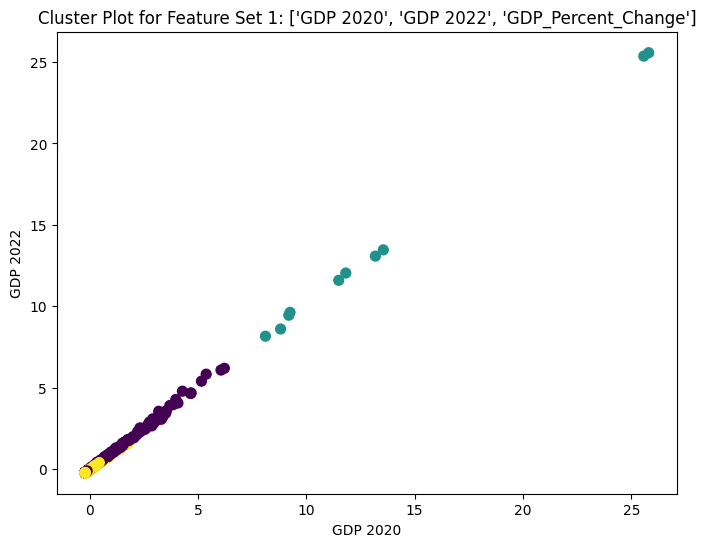

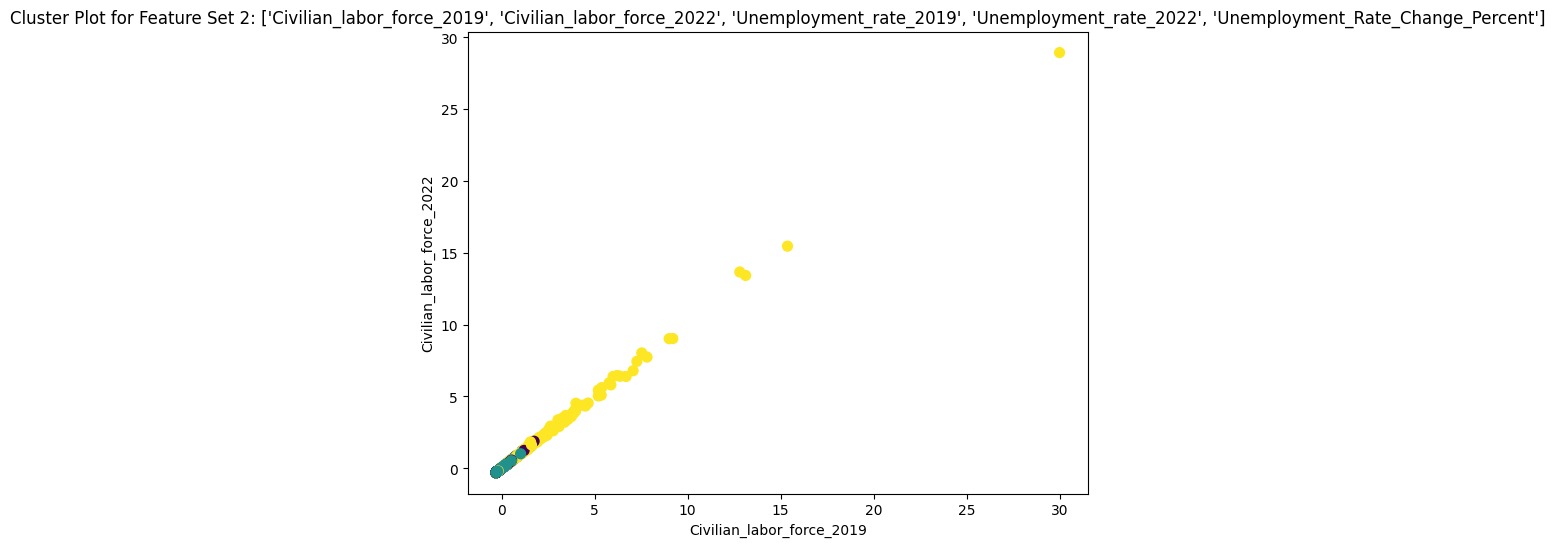

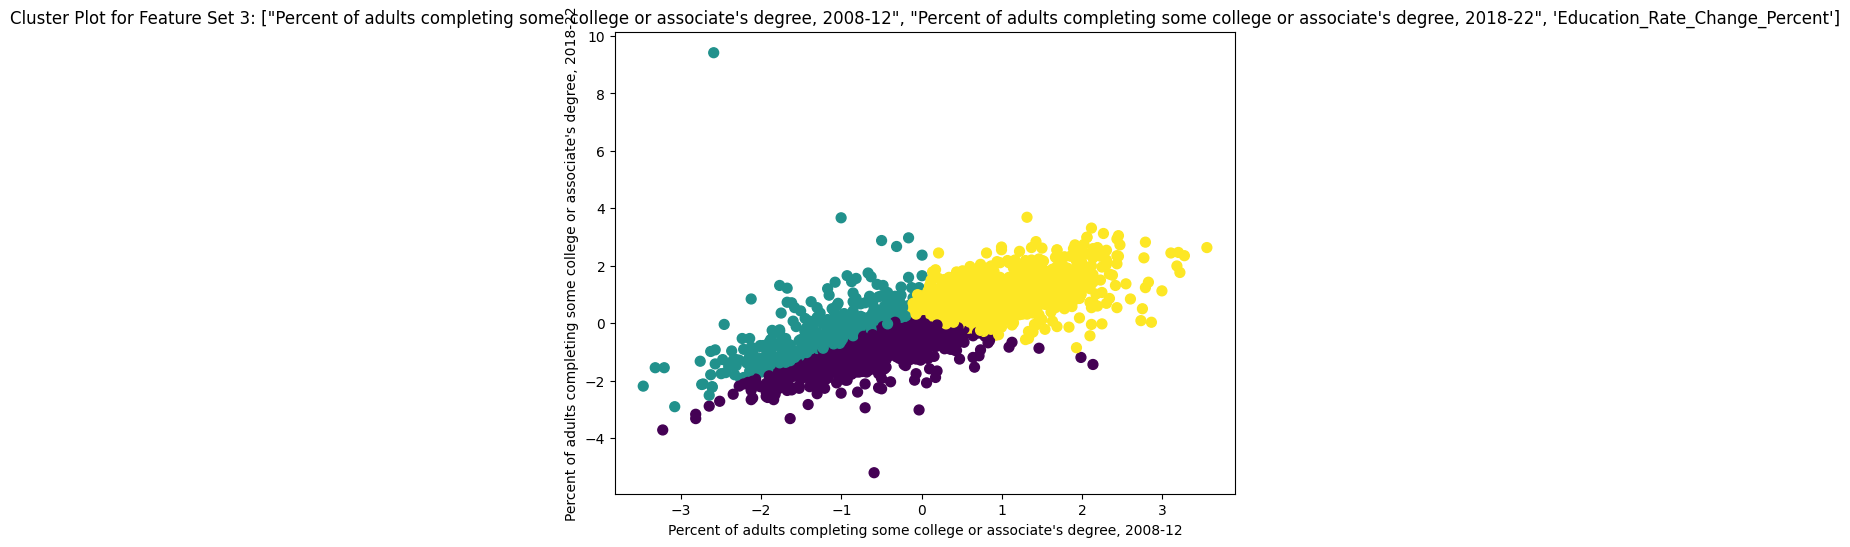

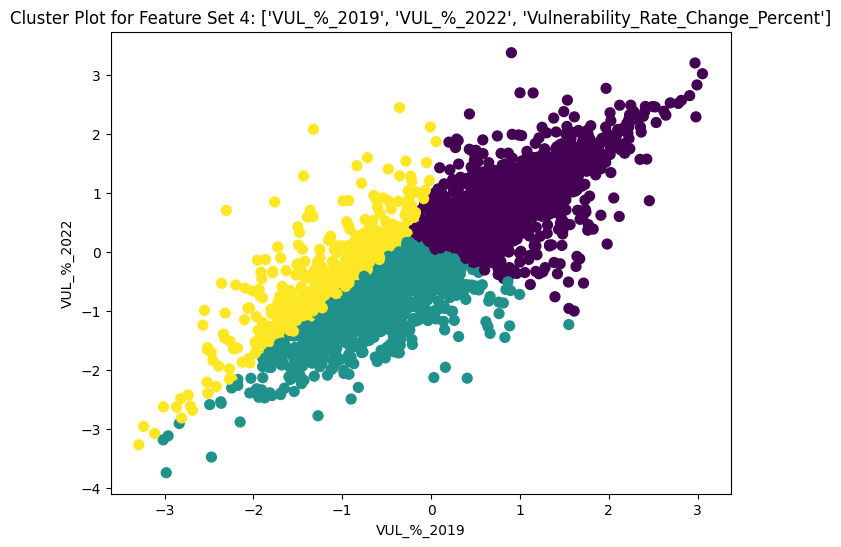

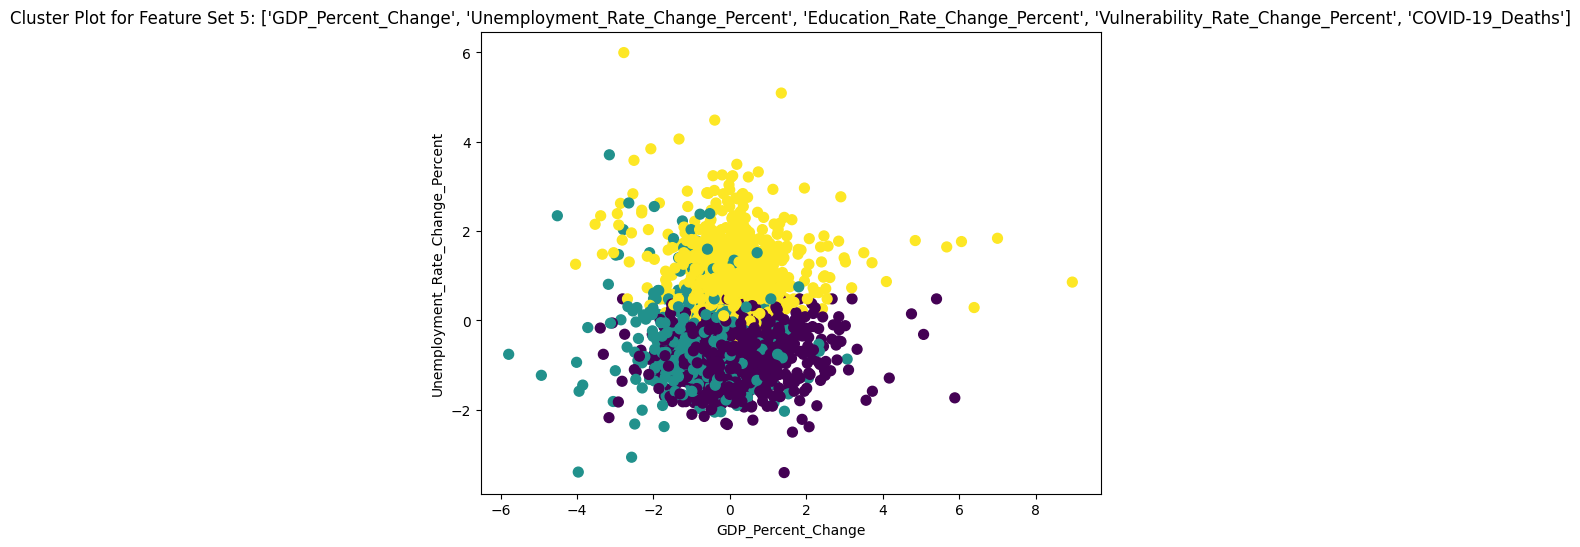

Best Feature Set: ['VUL_%_2019', 'VUL_%_2022', 'Vulnerability_Rate_Change_Percent']
Silhouette Score: 0.5502007695781773


In [42]:
# feature sets for GDP, employment, education, and vulnerability
feature_sets = [
    ['GDP 2020', 'GDP 2022', 'GDP_Percent_Change'],  # GDP Features
    ['Civilian_labor_force_2019', 'Civilian_labor_force_2022', 'Unemployment_rate_2019', 'Unemployment_rate_2022', 'Unemployment_Rate_Change_Percent'],  # Employment Features
    ['Percent of adults completing some college or associate\'s degree, 2008-12',
     'Percent of adults completing some college or associate\'s degree, 2018-22',
     'Education_Rate_Change_Percent'],  # Education Features
    ['VUL_%_2019', 'VUL_%_2022', 'Vulnerability_Rate_Change_Percent'],  # Vulnerability Features
    ['GDP_Percent_Change', 'Unemployment_Rate_Change_Percent', 'Education_Rate_Change_Percent', 'Vulnerability_Rate_Change_Percent']  # Combined Features
]

results = []

for i, features in enumerate(feature_sets):
    # Vectorize features
    assembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")
    vectorized_df = assembler.transform(df_final_one)

    # Standardize features
    scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
    scaled_df = scaler.fit(vectorized_df).transform(vectorized_df)

    # Apply KMeans
    kmeans = KMeans(k=3, seed=42, featuresCol="features")  # Adjust k as needed
    model = kmeans.fit(scaled_df)

    # Calculate Silhouette Score
    predictions = model.transform(scaled_df)
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(predictions)

    # Store the results
    results.append((i + 1, features, silhouette_score, predictions))

    #Plot the clusters (convert to Pandas for plotting)
    pandas_df = predictions.select("features", "prediction").toPandas()
    plt.figure(figsize=(8, 6))
    plt.scatter(
        pandas_df['features'].apply(lambda x: x[0]),
        pandas_df['features'].apply(lambda x: x[1]),
        c=pandas_df['prediction'], cmap='viridis', s=50
    )
    plt.title(f"Cluster Plot for Feature Set {i + 1}: {features}")
    plt.xlabel(features[0])
    plt.ylabel(features[1] if len(features) > 1 else 'Second Feature')
    plt.show()

# Identify the best cluster
best_result = max(results, key=lambda x: x[2]) 
print("Best Feature Set:", best_result[1])
print("Silhouette Score:", best_result[2])


In [43]:
results

[(1,
  ['GDP 2020', 'GDP 2022', 'GDP_Percent_Change'],
  0.4106918202155086,
  DataFrame[GEO_ID: string, COUNTY_NUMBER: int, NAME: string, POP_2019: int, VUL_2019: int, VUL_%_2019: double, POPUNI_2022: int, VUL_2022: int, VUL_%_2022: double, Vulnerability_Rate_Change_Percent: double, County: string, GDP 2020: double, GDP 2022: double, GDP_Percent_Change: double, FIPS: int, Area name: string, Some college or associate's degree, 2008-12: string, Percent of adults completing some college or associate's degree, 2008-12: double, Some college or associate's degree, 2018-22: string, Percent of adults completing some college or associate's degree, 2018-22: double, Education_Rate_Change_Percent: double, FIPS_Code: int, State: string, Area_Name: string, Civilian_labor_force_2019: int, Unemployed_2019: int, Unemployment_rate_2019: double, Civilian_labor_force_2022: int, Unemployed_2022: int, Unemployment_rate_2022: double, Median_Household_Income_2021: int, Unemployment_Rate_Change_Percent: doubl

In [48]:
selected_columns = [
    "GDP_Percent_Change",
    "Vulnerability_Rate_Change_Percent",
    "Education_Rate_Change_Percent",
    "Unemployment_Rate_Change_Percent"
]
data = df_final_one.select("FIPS", *selected_columns)
for col in selected_columns:
    mean_value = data.selectExpr(f"avg({col}) as mean_value").collect()[0]['mean_value']
    data = data.fillna({col: mean_value})

In [49]:
# Combine features into a single vector
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
data = assembler.transform(data)


In [50]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

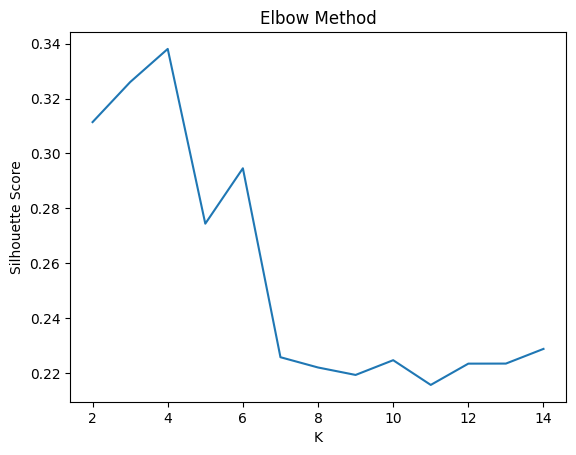

In [44]:
# Elbow Method to find optimal K Value

cost = []
for k in range(2, 15):  # Test K values from 2 to 9
    kmeans = KMeans(featuresCol="scaledFeatures", k=k)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    cost.append(evaluator.evaluate(predictions))

# Plot cost (you can use Matplotlib in a Python environment)
import matplotlib.pyplot as plt
plt.plot(range(2, 15), cost)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method')
plt.show()

In [51]:
# Initialize K-Means
kmeans = KMeans(featuresCol="scaledFeatures", k=3, seed=42)  # Adjust 'k' as needed
model = kmeans.fit(data)

# Get cluster predictions
clusters = model.transform(data)
result_with_fips = clusters.select("FIPS", "prediction")

# Show the result
result_with_fips.show(5)

+----+----------+
|FIPS|prediction|
+----+----------+
|1001|         2|
|1003|         2|
|1005|         0|
|1007|         1|
|1009|         2|
+----+----------+
only showing top 5 rows



In [52]:
result_with_fips.show(10)

+----+----------+
|FIPS|prediction|
+----+----------+
|1001|         2|
|1003|         2|
|1005|         0|
|1007|         1|
|1009|         2|
|1011|         1|
|1013|         1|
|1015|         1|
|1017|         1|
|1019|         2|
+----+----------+
only showing top 10 rows



In [45]:
# Add cluster predictions to the original dataset
clustered_data = clusters.select("GDP_Percent_Change", 
                                  "Vulnerability_Rate_Change_Percent", 
                                  "Education_Rate_Change_Percent", 
                                  "Unemployment_Rate_Change_Percent", 
                                  "prediction")


In [46]:
# Group by cluster and calculate averages for each feature
summary = clustered_data.groupBy("prediction").agg(
    {"GDP_Percent_Change": "avg",
     "Vulnerability_Rate_Change_Percent": "avg",
     "Education_Rate_Change_Percent": "avg",
     "Unemployment_Rate_Change_Percent": "avg"}
)
summary.show()


+----------+--------------------------------------+----------------------------------+-------------------------------------+-----------------------+
|prediction|avg(Vulnerability_Rate_Change_Percent)|avg(Education_Rate_Change_Percent)|avg(Unemployment_Rate_Change_Percent)|avg(GDP_Percent_Change)|
+----------+--------------------------------------+----------------------------------+-------------------------------------+-----------------------+
|         1|                     8.080856104846081|                11.997205145319436|                  -19.402968824478613|    0.10819574407740964|
|         2|                  -0.04659510930206875|                0.7985448801502486|                  -13.030069154313358|     15.143781425515838|
|         0|                    2.6464455419681987|                2.4730889365550914|                    8.132106848516518|      4.295819502431837|
+----------+--------------------------------------+----------------------------------+--------------------

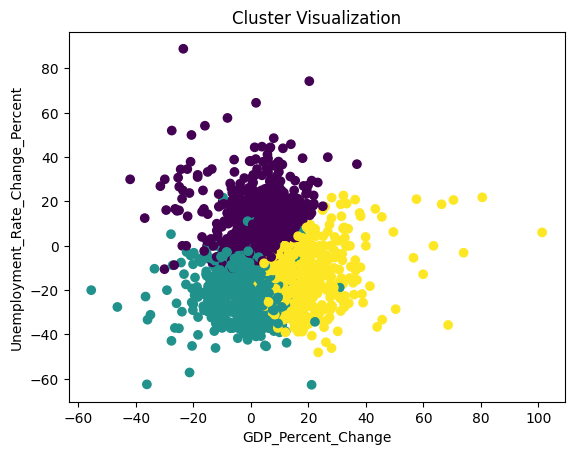

In [53]:
pandas_data = clusters.toPandas()
plt.scatter(pandas_data['GDP_Percent_Change'], pandas_data['Unemployment_Rate_Change_Percent'], c=pandas_data['prediction'])
plt.xlabel("GDP_Percent_Change")
plt.ylabel("Unemployment_Rate_Change_Percent")
plt.title("Cluster Visualization")
plt.show()

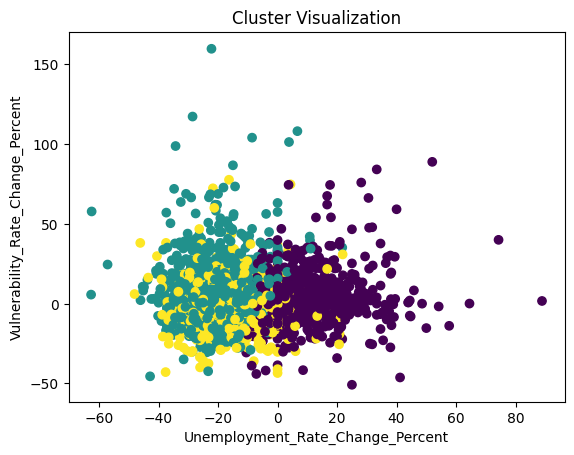

In [57]:
pandas_data = clusters.toPandas()
plt.scatter(pandas_data['Unemployment_Rate_Change_Percent'], pandas_data['Vulnerability_Rate_Change_Percent'], c=pandas_data['prediction'])
plt.xlabel("Unemployment_Rate_Change_Percent")
plt.ylabel("Vulnerability_Rate_Change_Percent")
plt.title("Cluster Visualization")
plt.show()

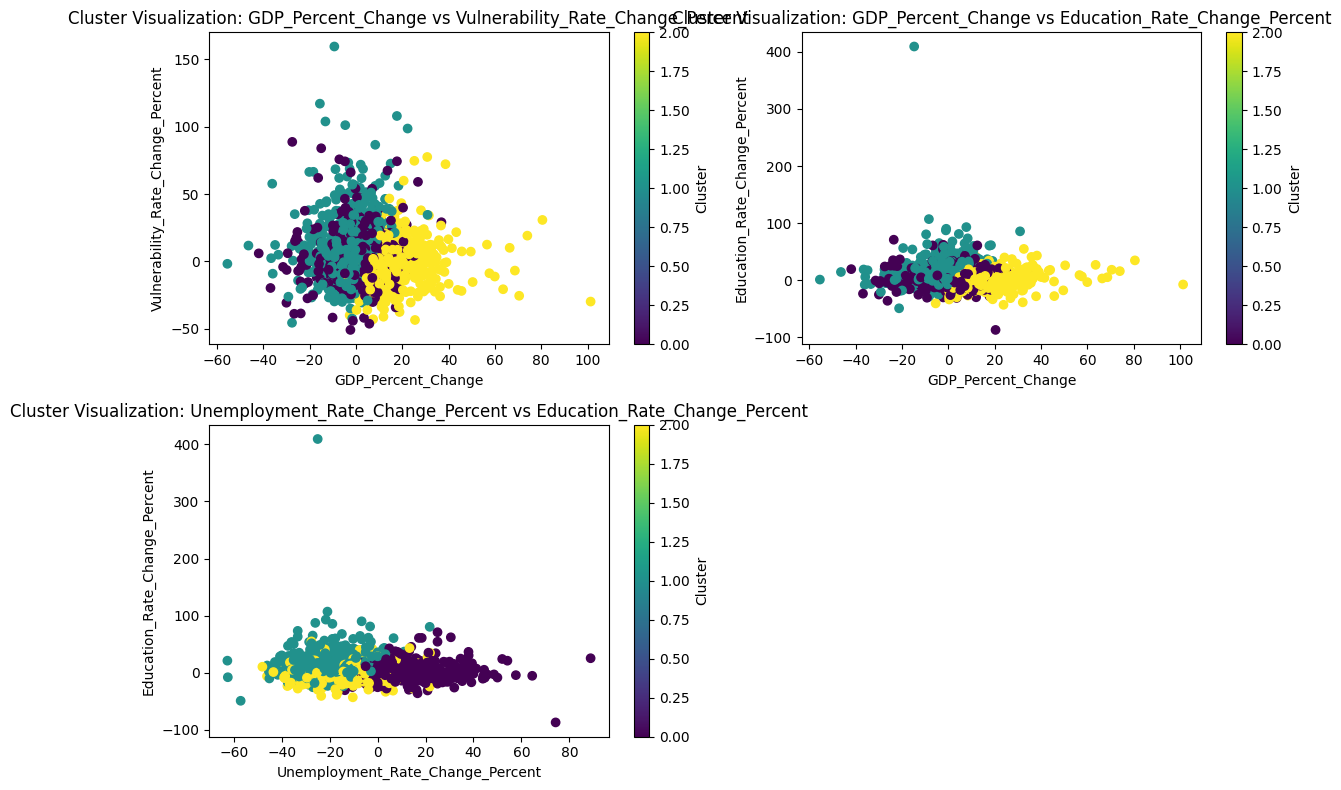

In [58]:
# Convert PySpark DataFrame to Pandas for visualization
pandas_df = clusters.select("GDP_Percent_Change", "Vulnerability_Rate_Change_Percent", 
                             "Education_Rate_Change_Percent", "Unemployment_Rate_Change_Percent", 
                             "prediction").toPandas()

# Plot pairwise scatter plots
plt.figure(figsize=(12, 8))
for i, (x_feature, y_feature) in enumerate([("GDP_Percent_Change", "Vulnerability_Rate_Change_Percent"),
                                            ("GDP_Percent_Change", "Education_Rate_Change_Percent"),
                                            ("Unemployment_Rate_Change_Percent", "Education_Rate_Change_Percent")]):
    plt.subplot(2, 2, i + 1)
    scatter = plt.scatter(pandas_df[x_feature], pandas_df[y_feature], c=pandas_df["prediction"], cmap="viridis")
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f"Cluster Visualization: {x_feature} vs {y_feature}")
plt.tight_layout()
plt.show()

## Regression Analysis

In this section, our goal is to find the regression coefficients for the entire dataset and also the regression coefficients for the clusters created in the previous section

### Regression model on entire dataset

In [64]:
# Clean the data by dropping rows with null values in the selected columns
clean_data = df_final_one.na.drop(subset=[
    "Unemployment_Rate_Change_Percent",
    "Education_Rate_Change_Percent",
    "GDP_Percent_Change",
    "Vulnerability_Rate_Change_Percent"
])

# Assemble features into a single column
assembler = VectorAssembler(
    inputCols=[
        "Education_Rate_Change_Percent",
        "GDP_Percent_Change",
        "Vulnerability_Rate_Change_Percent"
    ],
    outputCol="features"
)
assembled_data = assembler.transform(clean_data)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# Train the linear regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Unemployment_Rate_Change_Percent")
model = lr.fit(scaled_data)

# Print coefficients with respect to each feature
coefficients = model.coefficients
features = assembler.getInputCols() 

# Printing the coefficients with respect to each feature
print("Coefficients with respect to each feature:")
for feature, coeff in zip(features, coefficients):
    print(f"{feature}: {coeff}")
print(f"Intercept: {model.intercept}")

24/12/11 13:28:52 WARN Instrumentation: [3274d99e] regParam is zero, which might cause numerical instability and overfitting.


Coefficients with respect to each feature:
Education_Rate_Change_Percent: -1.7177912366297896
GDP_Percent_Change: 0.5595426306166262
Vulnerability_Rate_Change_Percent: 0.03985571224063648
Intercept: -7.478458552631408


### Regression model on each cluster

In [55]:
clustered_data.show()

+--------------------+---------------------------------+-----------------------------+--------------------------------+----------+
|  GDP_Percent_Change|Vulnerability_Rate_Change_Percent|Education_Rate_Change_Percent|Unemployment_Rate_Change_Percent|prediction|
+--------------------+---------------------------------+-----------------------------+--------------------------------+----------+
|    8.51595811970264|               6.6053059014618425|           0.3378378378378306|             -20.689655172413797|         2|
|  12.777792164711482|               -2.822466836014677|          -1.5723270440251573|              -17.24137931034483|         2|
|  1.7344782701928974|               2.5427444103463475|            7.751937984496124|               2.499999999999991|         0|
| -0.6985010111881679|              -1.4939915556999055|            6.274509803921574|              -24.24242424242424|         1|
|   13.73058366479811|                3.013003488740868|            16.974169741697

In [68]:
features = ['Education_Rate_Change_Percent',
            'GDP_Percent_Change', 
            'Vulnerability_Rate_Change_Percent']
target = 'Unemployment_Rate_Change_Percent'

for cluster_id in [0, 1, 2]:
    print(f"Running regression for cluster {cluster_id}")
    
    # Filter data for the current cluster
    cluster_data = clusters.filter(clusters['prediction'] == cluster_id)
    
    if 'features' in cluster_data.columns:
        cluster_data = cluster_data.drop('features')
    
    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    cluster_data = assembler.transform(cluster_data)
    
    # Prepare data for regression
    regression_data = cluster_data.select("features", target)
    
    # Initialize and train the regression model
    lr = LinearRegression(featuresCol="features", labelCol=target)
    lr_model = lr.fit(regression_data)
    
    # Output regression results
    print(f"Cluster {cluster_id} Regression Coefficients:")
    for feature, coef in zip(features, lr_model.coefficients):
        print(f"  {feature}: {coef}")
    print(f"Intercept: {lr_model.intercept}")
    print(f"R-squared: {lr_model.summary.r2}")
    print("-" * 50)


Running regression for cluster 0


24/12/11 13:43:51 WARN Instrumentation: [93908ac4] regParam is zero, which might cause numerical instability and overfitting.


Cluster 0 Regression Coefficients:
  Education_Rate_Change_Percent: -0.01804537993018673
  GDP_Percent_Change: -0.02918950872106434
  Vulnerability_Rate_Change_Percent: 0.11836152053986614
Intercept: 7.9888902204348415
R-squared: 0.02018513076564621
--------------------------------------------------
Running regression for cluster 1


24/12/11 13:43:57 WARN Instrumentation: [2c07afd3] regParam is zero, which might cause numerical instability and overfitting.


Cluster 1 Regression Coefficients:
  Education_Rate_Change_Percent: 0.058047797777264584
  GDP_Percent_Change: 0.021962513334901644
  Vulnerability_Rate_Change_Percent: 0.041920648922198635
Intercept: -20.44051114488061
R-squared: 0.021180358944248523
--------------------------------------------------
Running regression for cluster 2


24/12/11 13:44:02 WARN Instrumentation: [e2888e29] regParam is zero, which might cause numerical instability and overfitting.


Cluster 2 Regression Coefficients:
  Education_Rate_Change_Percent: 0.008805213219078546
  GDP_Percent_Change: 0.23172388773267558
  Vulnerability_Rate_Change_Percent: 0.0341495571692317
Intercept: -16.544685216793578
R-squared: 0.049999612489063816
--------------------------------------------------
